# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [ ]:
import pandas as pd
import numpy as np
# remove outliers
from scipy import stats as st
# plot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
# split
from sklearn.model_selection import train_test_split
# meodel
from sklearn.linear_model import LinearRegression
# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
# for google colab:
from google.colab import drive
drive.mount('/content/gdrive')

df_0 = pd.read_csv('gdrive/My Drive/Colab Notebooks/8-geo-location/data/geo_data_0.csv')#, sep='\t')
df_1 = pd.read_csv('gdrive/My Drive/Colab Notebooks/8-geo-location/data/geo_data_1.csv')#, sep='\t')
df_2 = pd.read_csv('gdrive/My Drive/Colab Notebooks/8-geo-location/data/geo_data_2.csv')#, sep='\t')

# for yandex jupiter:
#df_0 = pd.read_csv('/datasets/geo_data_0.csv')
#df_1 = pd.read_csv('/datasets/geo_data_1.csv')
#df_2 = pd.read_csv('/datasets/geo_data_2.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
-  `product` — объём запасов в скважине (тыс. баррелей).

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [ ]:
df_0['region'] = 'geo_0'
df_0.head(3)

,id,f0,f1,f2,product,region
0,txEyH,0.705745,-0.497823,1.221170,105.280062,geo_0
1,2acmU,1.334711,-0.340164,4.365080,73.037750,geo_0
2,409Wp,1.022732,0.151990,1.419926,85.265647,geo_0


In [ ]:
df_1['region'] = 'geo_1'
df_1.head(3)

,id,f0,f1,f2,product,region
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,geo_1
1,62mP7,14.272088,-3.475083,0.999183,26.953261,geo_1
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,geo_1


In [ ]:
df_2['region'] = 'geo_2'
df_2.head(3)

,id,f0,f1,f2,product,region
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,geo_2
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,geo_2
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,geo_2


In [ ]:
df = pd.concat([df_0, df_1, df_2]).reset_index(drop=True)

Анализ данных на наличие выбросов

In [ ]:
def df_plots(df, list_cols_names,
                      title_text='Boxblot', kind='Box',
                      rows=1, cols=1, height=500, width=800,
                      y_for_Bar=''):
  '''Function receives DataFrame data and list columns names,
  when builds Boxblot or Histogram or Bar
  - imports:
  import plotly.graph_objs as go
  from plotly.subplots import make_subplots'''

  fig = make_subplots(rows=rows, cols=cols)
  row = 1
  col = 1
  for col_name in list_cols_names:
    if kind == 'Box':
      fig.append_trace(go.Box(y=df[col_name], name=col_name), row, col)
    elif kind == 'Histogram':
      fig.append_trace(go.Histogram(y=df[col_name], name=col_name), row, col)
    elif kind == 'Bar':
      fig.append_trace(go.Bar(x=df[col_name],y=df[y_for_Bar],name=col_name), row, col)
    col += 1
    if col > cols:
      col = 1
      row +=1
  
  fig.update_layout(title_text=title_text, height=height, width=width)
  fig.show()

class myfunc:
  '''Custom functions'''
myfunc.df_plots =  df_plots

In [ ]:
myfunc.df_plots(df_0, ['f0','f1', 'f2', 'product'], df_0['region'][0],cols=4)
myfunc.df_plots(df_0, ['f0','f1', 'f2', 'product'], df_0['region'][0], 'Histogram', cols=4)

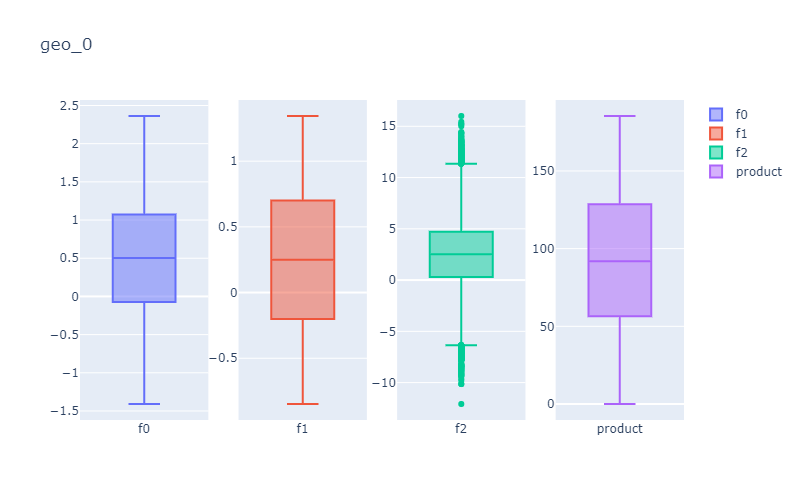

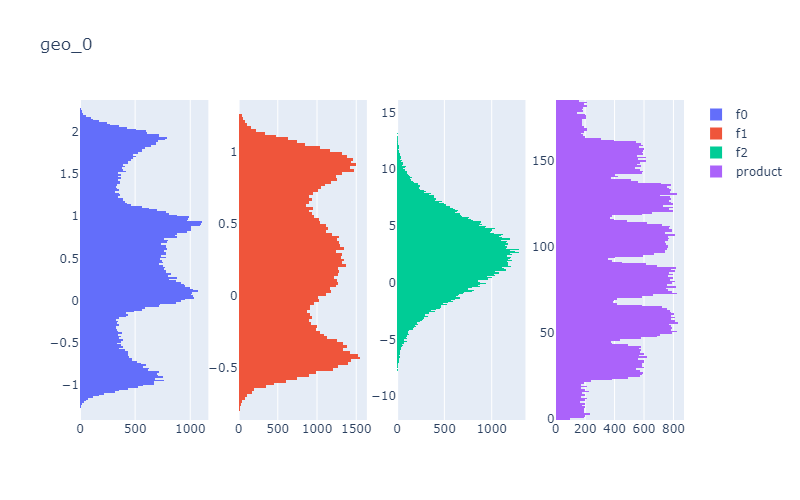

Удаление выбросов в стобце `f2`

In [ ]:
# remove outliers
df_0_copy = df_0.copy()
df_0 = df_0[df_0['f2'].between(df_0['f2'].quantile(.005), df_0['f2'].quantile(.995))]

In [ ]:
df_1_copy = df_1.copy()
myfunc.df_plots(df_1, ['f0','f1', 'f2', 'product'], df_1['region'][0],cols=4)
myfunc.df_plots(df_1, ['f0','f1', 'f2', 'product'], df_1['region'][0], 'Histogram', cols=4)

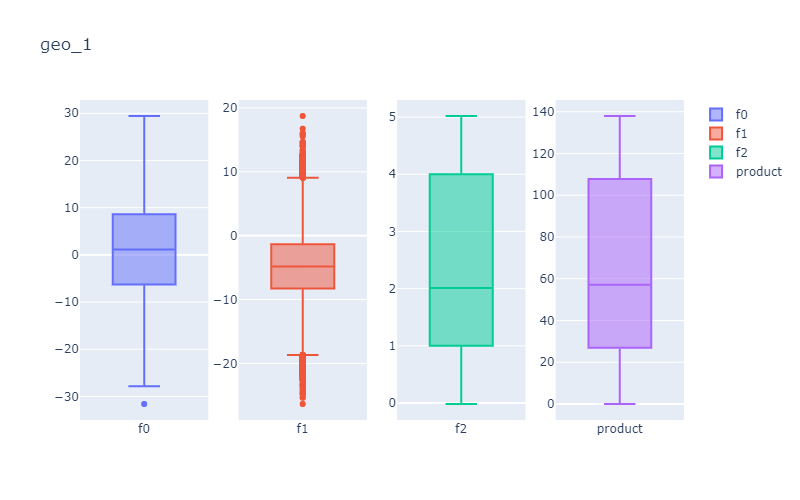

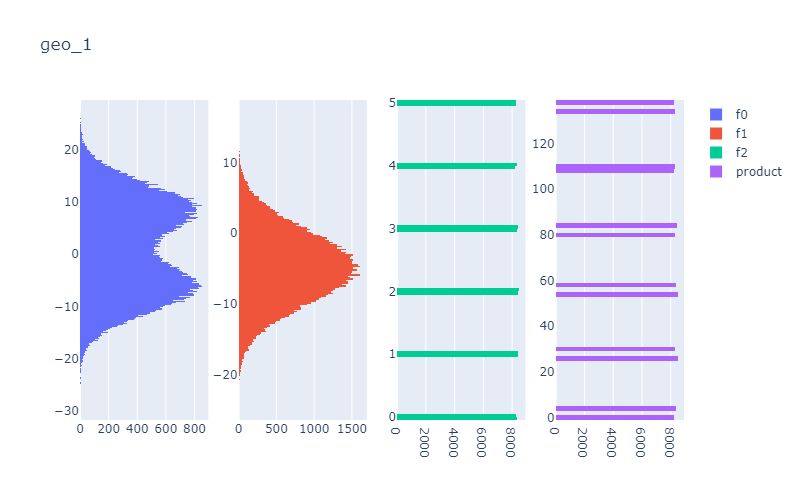

В данном регионе данные в столбцах `f2` и `product` выглядят ошибочными, после анализа корреляции будет сделан вывод что можно с ними сделать

In [ ]:
myfunc.df_plots(df_2, ['f0','f1', 'f2', 'product'], df_2['region'][0],cols=4)
myfunc.df_plots(df_2, ['f0','f1', 'f2', 'product'], df_2['region'][0], 'Histogram', cols=4)

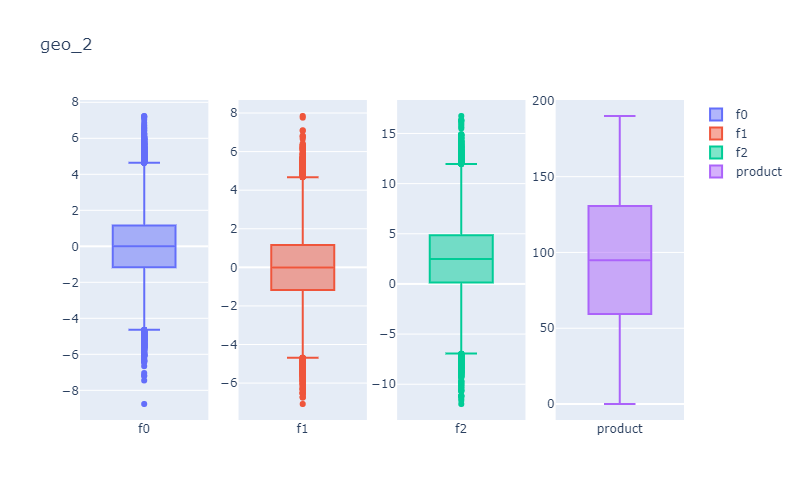

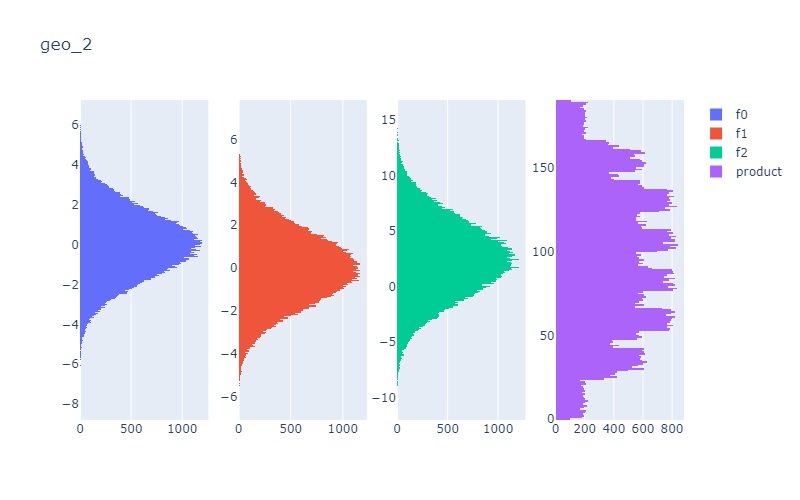

Удаление выбросов в стобцах

In [ ]:
# remove outliers
df_2_copy = df_2.copy()
df_2 = df_2[df_2['f0'].between(df_2['f0'].quantile(.005), df_2['f0'].quantile(.995))]
df_2 = df_2[df_2['f1'].between(df_2['f1'].quantile(.005), df_2['f1'].quantile(.995))]
df_2 = df_2[df_2['f2'].between(df_2['f2'].quantile(.005), df_2['f2'].quantile(.995))]

Анализ корреляции

In [ ]:
df_0.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,f0,f1,f2,product
f0,1.00,-0.44,-0.00,0.14
f1,-0.44,1.00,0.00,-0.19
f2,-0.00,0.00,1.00,0.48
product,0.14,-0.19,0.48,1.00


In [ ]:
df_1.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,f0,f1,f2,product
f0,1.00,0.18,-0.00,-0.03
f1,0.18,1.00,-0.00,-0.01
f2,-0.00,-0.00,1.00,1.00
product,-0.03,-0.01,1.00,1.00


In [ ]:
df_2.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,f0,f1,f2,product
f0,1.00,0.00,0.00,-0.00
f1,0.00,1.00,0.00,0.00
f2,0.00,0.00,1.00,0.44
product,-0.00,0.00,0.44,1.00


В регионах geo_0 и geo_2 корреляция `f2` к `product` имеет близкие значения, при этом у geo_1 корреляция 1, что вызывает как вопросы о том верные ли значения в `f2` и верно ли моделью рассчитаны значения `product`. Возможности исправить значения `f2` в geo_1 нет, соответственно этот регион не будет рассматриваться в дальнейшем анализе.

Анализ пропусков, нулей и дубликатов

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
 5   region   300000 non-null  object 
dtypes: float64(4), object(2)
memory usage: 13.7+ MB


In [ ]:
df.describe()

,f0,f1,f2,product
count,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.547913,-1.516172,2.497439,85.441667
std,5.316634,3.900220,2.916502,46.519494
min,-31.609576,-26.358598,-12.088328,0.000000
25%,-1.003037,-2.478939,0.648213,52.666629
50%,0.347934,-0.229632,2.491215,84.038886
75%,1.755365,0.678562,4.344943,124.174086
max,29.421755,18.734063,16.739402,190.029838


In [ ]:
df.duplicated().sum()

0

In [ ]:
df[df['product'] == 0]['region'].value_counts()

geo_1    8235
geo_0       1
geo_2       1
Name: region, dtype: int64

## Вывод

- Данные загружены, а также для удобства дальнейшего анализа объединены в один датафрейм.
- В регионах geo_0 и geo_2 корреляция f2 к product имеет близкие значения, при этом у geo_1 корреляция 1, что вызывает как вопросы о том верные ли значения в f2 и верно ли моделью рассчитаны значения product. Возможности исправить значения f2 в geo_1 нет, соответственно этот регион не будет рассматриваться в дальнейшем анализе.
- были удалены выбросы и проведен анализ коррелиции
- дубликаты не найдень, были найдены нули в данных, так как корреляция признаков в каждом региона разная, то будут построены 2 модели для заполнения нулей

## Обучение и проверка модели

In [ ]:
def split_df(df, list_dpop_cols_names, target_col_name, cv=False):
  '''Function receives DataFrame, split it to train (60%), valid (20%), test (20%) data,
  also receives list of names columns to drop and target column name.
  Returns data as dict,
  Function also print the splitted data shape
  If cv=True function returns dict with train 75% and test 25% data
  - imports:
  from sklearn.model_selection import train_test_split'''
  list_dpop_cols_names.append(target_col_name)
  X = df.drop(list_dpop_cols_names, axis=1)
  y = df[target_col_name]
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=123456)
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=123456)
  
  if cv:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=123456)
    print('X_train:',X_train.shape,'X_test:', X_test.shape)
    return {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
  else:
    print('X_train:',X_train.shape,'X_valid:',X_valid.shape,'X_test:', X_test.shape)
    return {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}

myfunc.split_df = split_df

## Подготовка к расчёту прибыли

Создание переменных и присвоение им значений соответствующих условию задачи

In [ ]:
TOTAL_DOTS = 500
TOTAL_BEST_DOTS = 200
BUDJET_MRD_RUB = 10
PROFIT_FROM_1_PRODUCT_MRD = 0.00045
PROBABILITY_LOSS_PERCENT = 2.5

Функция для расчета прибыли

In [ ]:
def profit_count (df, head_count, profit_from_1_product_mrd, budjet_mrd_rub):
    df = df.sort_values(by='product', ascending=False).reset_index(drop=True)
    df_head = df.head(head_count)
    total_product = df_head['product'].sum()
    profit = total_product * profit_from_1_product_mrd - budjet_mrd_rub
    return profit

Функция для бутстреп

In [ ]:
def bootstrap_count(df, sample_count, head_count, profit_from_1_product_mrd, budjet_mrd_rub, bootstrap_size):
  '''Function receives DataFrame, value to select sample, value select head rows
  and commercial data. 
  Function "bootstrap_size" times takes sample, sort, take head and
  counts the sum (it uses another function profit_count()).
  Returns list of sums. And also prints mean sum, persent negative amount and
  95% confidence interval.
  - imports:
  from scipy import stats as st'''
  state = np.random.RandomState(12345)
  values = []
  for i in range(bootstrap_size):
    df_subsample_500 = df.sample(n=sample_count, replace=True, random_state=state)
    profit = profit_count(df_subsample_500, head_count, profit_from_1_product_mrd, budjet_mrd_rub)
    values.append(profit)

  values = pd.Series(values)
  values_below_zero = len([i for i in values if i < 0]) / values.count()
  #values_below_zero = values[values < 0].count() / values.count()
  print("Средняя выручка млрд: {:.3}".format(values.mean()))
  print("Риск убытков: {:.1%}".format(values_below_zero))

  confidence_interval = st.t.interval(alpha=0.95,
                                      df=(len(values) - 1),
                                      loc=values.mean(),
                                      scale=values.sem()
                                      )
  confidence_interval = tuple(map(lambda x: isinstance(x, float) and round(x, 2) or x, confidence_interval)) # rounding
  print("95% доверительный интервал истинного среднего:", confidence_interval)
    
  confidence_interval_predict = (values.quantile(0.025), values.quantile(0.975))
  confidence_interval_predict = tuple(map(lambda x: isinstance(x, float) and round(x, 2) or x, confidence_interval_predict)) # rounding
  print("95% доверительный интервал прогноза:", confidence_interval_predict)
  return values

myfunc.bootstrap_count = bootstrap_count

## Вывод

Созданы функция и переменные для расчета прибыли

## Расчёт прибыли и рисков 

Рассчет достаточный объём сырья для безубыточной разработки новой скважины.


In [ ]:
mean_stock = round(BUDJET_MRD_RUB / (TOTAL_BEST_DOTS * PROFIT_FROM_1_PRODUCT_MRD), 2)
print('Для безубыточной разработки скважины, средний запас в ней должен быть:', mean_stock)

Для безубыточной разработки скважины, средний запас в ней должен быть: 111.11


Средний запас в скважине по регионам:

In [ ]:
df_mean_stock = pd.pivot_table(df,
                               values='product',
                               index='region',
                               aggfunc='mean')
df_mean_stock['mean_stock'] = mean_stock
df_mean_stock['proportion'] = round(df_mean_stock['product'] / mean_stock, 2)
df_mean_stock

,product,mean_stock,proportion
region,,,
geo_0,92.500,111.11,0.83
geo_1,68.825,111.11,0.62
geo_2,95.000,111.11,0.86


Вывод: средние запасы скважин ниже безубыточного уровня

Расчет прибыли по региону geo_0

Средняя выручка млрд: 2.39
Риск убытков: 0.0%
95% доверительный интервал истинного среднего: (2.38, 2.41)
95% доверительный интервал прогноза: (2.02, 2.79)


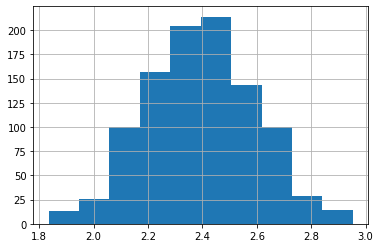

In [ ]:
values = myfunc.bootstrap_count(df_0_copy, TOTAL_DOTS, TOTAL_BEST_DOTS, PROFIT_FROM_1_PRODUCT_MRD, BUDJET_MRD_RUB, 1000)
values.hist()

Расчет прибыли по региону geo_1

Средняя выручка млрд: 0.45
Риск убытков: 1.4%
95% доверительный интервал истинного среднего: (0.44, 0.46)
95% доверительный интервал прогноза: (0.04, 0.83)


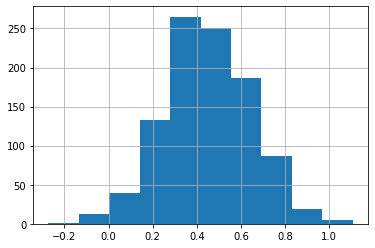

In [ ]:
values = myfunc.bootstrap_count(df_1_copy, TOTAL_DOTS, TOTAL_BEST_DOTS, PROFIT_FROM_1_PRODUCT_MRD, BUDJET_MRD_RUB, 1000)
values.hist()

Расчет прибыли по региону geo_2

Средняя выручка млрд: 2.63
Риск убытков: 0.0%
95% доверительный интервал истинного среднего: (2.62, 2.65)
95% доверительный интервал прогноза: (2.23, 3.06)


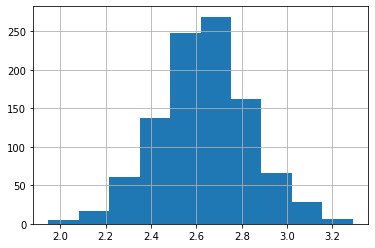

In [ ]:
values = myfunc.bootstrap_count(df_2_copy, TOTAL_DOTS, TOTAL_BEST_DOTS, PROFIT_FROM_1_PRODUCT_MRD, BUDJET_MRD_RUB, 1000)
values.hist()

## Вывод

Средняя выручка в регионе geo_2 выше, чем в geo_1, доверительный интервал также выше в geo_2. Процент отрицательной выручки в обоих регионах отсутствует.

# Общий вывод

- В регионах geo_0 и geo_2 корреляция f2 к `product` имеет близкие значения, при этом у geo_1 корреляция 1, что вызывает как вопросы о том верные ли значения в f2 и верно ли моделью рассчитаны значения product. Возможности исправить значения f2 в geo_1 нет, соответственно этот регион не рассматривался в анализе.
- дубликаты не найдень, были найдены нули в данных, так как корреляция признаков в каждом региона разная, то были построены 2 модели и нулевые значения в столбце `product` заполнены предсказанными значениями
- Средняя выручка в регионе geo_2 выше, чем в geo_1, доверительный интервал также выше в geo_2. Процент отрицательной выручки в обоих регионах отсутствует.

Разделение выборок на обучающую и тестовую

In [ ]:
df_0_splitted = myfunc.split_df(df_0_copy, ['id', 'region'],'product' , True)
df_1_splitted = myfunc.split_df(df_1_copy, ['id', 'region'],'product' , True)
df_2_splitted = myfunc.split_df(df_2_copy, ['id', 'region'],'product' , True)

X_train: (75000, 3) X_test: (25000, 3)
X_train: (75000, 3) X_test: (25000, 3)
X_train: (75000, 3) X_test: (25000, 3)


Создание и обучение моделей

In [ ]:
model_df_0 = LinearRegression().fit(df_0_splitted['X_train'], df_0_splitted['y_train'])
model_df_1 = LinearRegression().fit(df_1_splitted['X_train'], df_1_splitted['y_train'])
model_df_2 = LinearRegression().fit(df_2_splitted['X_train'], df_2_splitted['y_train'])

Присвоение переменным результатов предсказаний модели

In [ ]:
predictions_0 = model_df_0.predict(df_0_splitted['X_test'])
prediction_df_0 = pd.DataFrame(predictions_0, columns =['product'])
print("R2 df_0 =", r2_score(df_0_splitted['y_test'], predictions_0))
predictions_1 = model_df_0.predict(df_1_splitted['X_test'])
prediction_df_1 = pd.DataFrame(predictions_1, columns =['product'])
print("R2 df_1 =", r2_score(df_1_splitted['y_test'], predictions_1))
predictions_2 = model_df_2.predict(df_2_splitted['X_test'])
prediction_df_2 = pd.DataFrame(predictions_2, columns =['product'])
print("R2 df_2 =", r2_score(df_2_splitted['y_test'], predictions_2))

R2 df_0 = 0.2762145023595348
R2 df_1 = -6.694082162576396
R2 df_2 = 0.1964535016292327


Показатель R2  у модели df_1 очень низкий, попробую обучить модель убрав нулевые строки

In [ ]:
df_1_no_zeros = df_1_copy[df_1_copy['product'] != 0]
df_1_splitted_no_zeros = myfunc.split_df(df_1_no_zeros, ['id', 'region'],'product' , True)

model_df_1_no_zeros = LinearRegression().fit(df_1_splitted_no_zeros['X_train'], df_1_splitted_no_zeros['y_train'])

prediction_1_no_zeros = model_df_1.predict(df_1_splitted['X_test'])
prediction_df_1_no_zeros = pd.DataFrame(prediction_1_no_zeros, columns =['product'])
print("R2 df_1 =", r2_score(df_1_splitted['y_test'], prediction_1_no_zeros))

X_train: (68823, 3) X_test: (22942, 3)
R2 df_1 = 0.9996240224383129


Без нулевых строк показатель почти идеальный, оно и понятно - корреляция f2 и product равна 1

Расчет прибыли по региону geo_0

Средняя выручка млрд: 0.353
Риск убытков: 0.1%
95% доверительный интервал истинного среднего: (0.35, 0.36)
95% доверительный интервал прогноза: (0.14, 0.59)


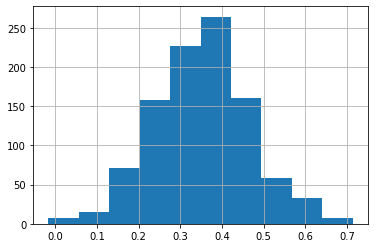

In [ ]:
values = myfunc.bootstrap_count(prediction_df_0, TOTAL_DOTS, TOTAL_BEST_DOTS, PROFIT_FROM_1_PRODUCT_MRD, BUDJET_MRD_RUB, 1000)
values.hist()

Расчет прибыли по региону geo_0

Средняя выручка млрд: 11.5
Риск убытков: 0.0%
95% доверительный интервал истинного среднего: (11.5, 11.54)
95% доверительный интервал прогноза: (10.8, 12.25)


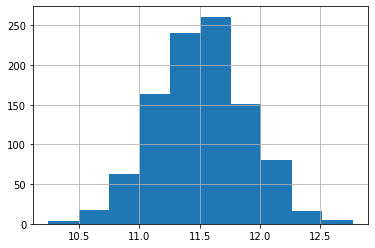

In [ ]:
values = myfunc.bootstrap_count(prediction_df_1, TOTAL_DOTS, TOTAL_BEST_DOTS, PROFIT_FROM_1_PRODUCT_MRD, BUDJET_MRD_RUB, 1000)
values.hist()

Расчет прибыли по региону geo_0 на предсказаниях модели, обученной по выборке без нулей

Средняя выручка млрд: 0.461
Риск убытков: 0.8%
95% доверительный интервал истинного среднего: (0.45, 0.47)
95% доверительный интервал прогноза: (0.09, 0.88)


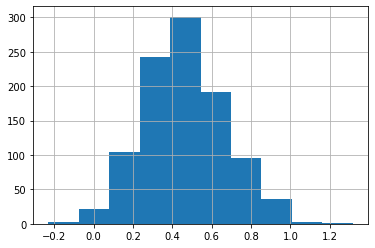

In [ ]:
values = myfunc.bootstrap_count(prediction_df_1_no_zeros, TOTAL_DOTS, TOTAL_BEST_DOTS, PROFIT_FROM_1_PRODUCT_MRD, BUDJET_MRD_RUB, 1000)
values.hist()

Средняя выручка млрд: 0.268
Риск убытков: 0.5%
95% доверительный интервал истинного среднего: (0.26, 0.27)
95% доверительный интервал прогноза: (0.07, 0.46)


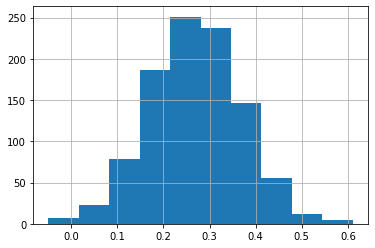

In [ ]:
values = myfunc.bootstrap_count(prediction_df_2, TOTAL_DOTS, TOTAL_BEST_DOTS, PROFIT_FROM_1_PRODUCT_MRD, BUDJET_MRD_RUB, 1000)
values.hist()

# Итоговый вывод

Средняя выручка в регионе geo_1 выше, чем в остальных, как на модели которая была обучена на данных без нулевых строк, так и на модели обученной на всех данных. Но так как модель обученная на всех строках показывает низкое значение метрики R2, то использовать эти данные не рекомендуется.